# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>Darknet Overview</b> 

___
# <b>Table of Content</b> <a id="toc_"></a>
* [<b>Darknet Traffic Overview</b>](#darknet)  
  * [Port Ranking](#portranking)  
  * [Darknet IPs Activity Pattern](#darknetpattern)  
  * [Dataset Statistics](#dataset)  
  * [Filter Definition](#darknetfilter)  
  * [Distinct IPs Seen Over 30 Days](#darknetips)  
  * [Last Day of Traffic](#lastday)  
    * [Some Notable GT Activity Patterns](#gtpattern)
  * [Ground Truth/Services Incidence](#gtserv)  
  

This notebook provides an overview of the collected darknet traffic. We go through the paper reporting the snippets that generate the statistics and the reported Figures. Namely, this report is related to Section 3 of the paper.

___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

In [1]:
from config import *
from src.callbacks import *
from src.utils import *
from src.knngraph import *
from src.review import *

import pandas as pd
import numpy as np
import warnings
import json
from glob import glob

from pandas.core.common import SettingWithCopyWarning
from pandas.errors import DtypeWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DtypeWarning)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler
plt.rcParams["font.family"] = "serif"


cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

___
# <b>Darknet Traffic Overview</b> <a name="darknet"></a>



Load 30 days of raw traffic. From 2021-03-02 to 2021-03-31. This is the full dataset we use in our experiments. 

Here we load an already slightly preprocessed dataset. In [Appendix 3](A03-darknet-checkpoint.ipynb) we provide the scripts for generating this intermediate dataset.

Each row of the dataset is a packet received from the darknet. The dataset columns are:

- `ts`. It is the timestamp of the packet arrival
- `ip`. It is the source IP address sending the packet
- `port`. It is the destination (darknet) port
- `proto`. Used protocol among TCP, UDP, ICMP, GRE, OTH (for others)
- `pp`. `port/proto` pairs used forthis load roughly 6 days only the language definition
- `class`. Ground truth class of the source IP

## Swap the lines below to read the full dataset - As it is now, it loads roughly 6 days only

In [3]:
%%time

# this load roughly 6 days only
# darknet = pd.read_csv(f'{DATASETS}/darknet.csv.gz', nrows=10000000)

# this will read the whole dataset - at least 32 GB of memory is required
darknet = pd.read_csv(f'{DATASETS}/darknet.csv.gz') 

darknet.head()

Wall time: 56.6 s


,ts,ip,port,proto,pp,class
0,2021-03-03 05:20:26.686132,165.172.152.128,445,TCP,445/TCP,unknown
1,2021-03-03 05:20:26.691946,158.86.51.237,16523,TCP,16523/TCP,unknown
2,2021-03-03 05:20:26.784749,19.160.222.118,5353,TCP,5353/TCP,unknown
3,2021-03-03 05:20:26.878851,210.105.89.28,7070,TCP,7070/TCP,unknown
4,2021-03-03 05:20:26.895800,194.209.229.65,445,TCP,445/TCP,unknown


In [4]:
print(f'Traffic stats: ')
print(f'{darknet.ip.unique().shape[0]:,} distinct source IPs')
print(f"{darknet.pp.unique().shape[0]:,} destination 'port/protocol' pairs.")
print(f'{darknet.shape[0]:,} received packets')
print(f'Dataset shape: {darknet.shape}')

Traffic stats: 
543,900 distinct source IPs
84,810 destination 'port/protocol' pairs.
63,562,427 received packets
Dataset shape: (63562427, 6)


### <b>Port Ranking</b> <a name="portranking"></a>  


Next we characterize the darknet. We focus on the port popularity in terms of received packets. 

In [5]:
# Get the port frequency from 30 days of traffic
top14 = darknet.value_counts('port').reset_index().rename(columns={0:'pkts'})
# Compute the ECDF(packets)
pkts = top14.sort_values('pkts', ascending=False)
pkts.pkts = np.cumsum(pkts.pkts)/np.sum(pkts.pkts)
# Zoom-in: Get the top-14 ports within 30 days
top = top14.sort_values('pkts', ascending=False)
top.pkts = np.cumsum(top.pkts)/np.sum(top14.pkts)
top = top.iloc[:14]

<Figure size 640x480 with 0 Axes>

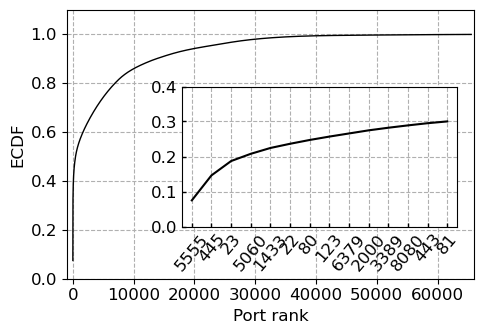

In [8]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig1a(plt, pkts, top),
                      cycler=cc, figsize=(5, 3.5), fontsize=12)
plt.savefig('./overview.eps', format='eps')
plot.show()

In [9]:
print(top)

     port      pkts
0     445  0.102637
1      23  0.197528
2    1433  0.223877
3      80  0.247323
4   52869  0.270196
5      22  0.287809
6    8080  0.304903
7      81  0.320916
8    5555  0.333547
9    3389  0.345358
10   2323  0.355347
11   8545  0.364695
12   8088  0.372905
13  37215  0.379160


### <b>Darknet IPs Activity Pattern</b> <a name="darknetpattern"></a>  


To provide the big picture, we visualize some IP addresses activity pattern.

We extract a time window shorter than 30 days and downsample the received traffic (modulo 3) to make the patterns more evident. Then a scatterplot is generated. Here, each dot is a packet sent by an IP $y$ at the istant $x$.

In [9]:
# Extract a 9 days window to make the IPs patterns more evident
tday_ = darknet[darknet.ts<='2021-3-11 23:28:56.952226'][['ts', 'ip']]
tday = pd.DataFrame(tday_, columns=['ts', 'ip'])
# Manage timestamps and sort them
tday.index = pd.DatetimeIndex(tday.ts)
tday = tday.sort_index()
tday = tday.drop(columns=['ts'])
# Tokenize IPs. From string to integer number
ydict = {v: k for k,v in enumerate(tday.ip.unique())}
tday['tkn'] = tday.ip.apply(lambda x: ydict[x])
# mod3 downsampling for reducing the image weight
resampled_idx = [x for x in range(tday.shape[0]) if x%3 == 0]
tday = tday.iloc[resampled_idx]

<Figure size 640x480 with 0 Axes>

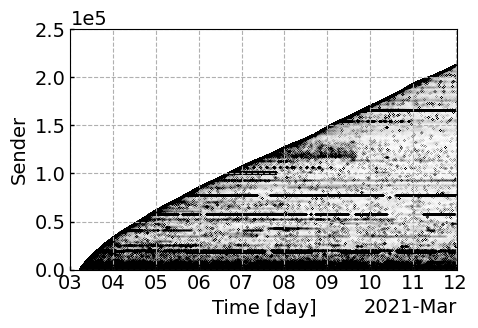

In [15]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig1b(plt, tday),
                      cycler=cc, figsize=(5, 3.5), fontsize=14)
plt.savefig('./overview_eu.png', dpi=300)
plot.show()

### <b>Dataset Statistics</b> <a name="dataset"></a>  

We improve the knowledge about the dataset by providing some statistics for both 30 days of darknet traffic and 1 day. In this second case the considered day is the 30^{th} of the full dataset.

In [14]:
with open(f'{DATA}/services/services.json', 'r') as file:
    services = json.loads(file.read())

In [21]:
# Load the 30 days dataset (df30) and the single day one (df1)
# this load roughly 6 days only
# df30 = pd.read_csv(f'{DATASETS}/darknet.csv.gz', nrows=10000000)
# this will read the whole dataset - at least 32 GB of memory is required
# df30 = pd.read_csv(f'{DATASETS}/darknet.csv.gz')
# df1 = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
df30 = darknet

In [22]:
# Number of IPs
# ip1 = df1.ip.unique().shape[0]
ip30 = df30.ip.unique().shape[0]
# Number of packets
# pkts1 = df1.shape[0]
pkts30 = df30.shape[0]
# Number of ports
# port1 = df1.port.unique().shape[0]
port30 = df30.port.unique().shape[0]
# Top-3 ports
# top3_1 = df1.value_counts('pp').index[:3]
top3_30 = df30.value_counts('pp').index[:3]
# Packets of top-3 ports
# top3pkts1 = (df1.value_counts('pp')/df1.shape[0]*100).values[:3]
top3pkts30 = (df30.value_counts('pp')/df30.shape[0]*100).values[:3]

Get the IPs targeting the top-3 ports of the considered datasets

In [13]:
df1[df1.pp.isin(top3_1)].groupby('pp').agg({'ip':lambda x: len(set(x))})

NameError: name 'df1' is not defined

In [23]:
df30[df30.pp.isin(top3_30)].groupby('pp').agg({'ip':lambda x: len(set(x))})

,ip
pp,
1433/tcp,8389
23/tcp,63541
445/tcp,44416


In [24]:
# Collect statistics
print('Date ($YYYY-MM-DD$):')
# print(f'\tLast Day: 2021-03-31')
print(f'\tFull Dataset: [2021-03-02, 2021-03-31]')

print('Sources:')
# print(f'\tLast Day: {ip1}')
print(f'\tFull Dataset: {ip30}')

print('Packets:')
# print(f'\tLast Day: {pkts1}')
print(f'\tFull Dataset: {pkts30}')

print('Ports:')
# print(f'\tLast Day: {port1}')
print(f'\tFull Dataset: {port30}')

print('Top-3 ports (\% of traffic):')
# print(f'\tLast Day: {top3_1[0]} ({round(top3pkts1[0], 2)}\%), {top3_1[1]} ({round(top3pkts1[1], 2)}\%),{top3_1[2]} ({round(top3pkts1[2], 2)}\%)')
print(f'\tFull Dataset: {top3_30[0]} ({round(top3pkts30[0], 2)}\%), {top3_30[1]} ({round(top3pkts30[1], 2)}\%),{top3_30[2]} ({round(top3pkts30[2], 2)}\%)')

Date ($YYYY-MM-DD$):
	Full Dataset: [2021-03-02, 2021-03-31]
Sources:
	Full Dataset: 65520
Packets:
	Full Dataset: 11309393
Ports:
	Full Dataset: 38826
Top-3 ports (\% of traffic):
	Full Dataset: 445/tcp (9.89\%), 23/tcp (9.06\%),1433/tcp (2.61\%)


### <b>Filter Definition</b> <a name="darknetfilter"></a>  


Given the large amount of packets received in 30 days, a filter is needed to improve visualization and reduce noisy traffic (e.g., senders that send only a couple of packets in a month are not interesting for this analysis). 

We design our filter with respect to the monthly packets sent by each IP. We evaluate the distribution of this amount and set the filtering threshold to 10 packets. In this way, we keep the IP addresses sending _at least 10 packets over a month_.

In [16]:
# Count the packets per IP over a month
cdf = darknet.value_counts('ip').reset_index().drop(columns=['ip'])\
             .rename(columns={0:'pkts'}).value_counts('pkts')
# Get the ECDF
cdf = cdf.sort_index()
cdf = np.cumsum(cdf)/np.sum(cdf)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

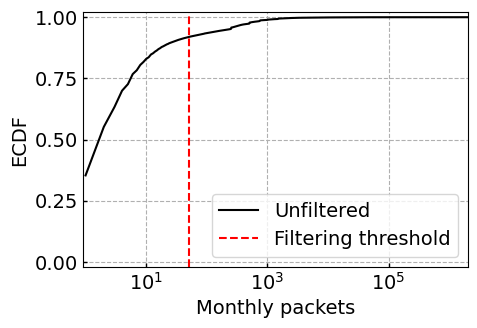

In [17]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig2a(plt, cdf),
                      cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.savefig('f1a_eu.eps', format='eps')
plot.show()

In [10]:
plot.savefig('f1a.eps', format='eps')

<Figure size 640x480 with 0 Axes>

### <b>Distinct IPs Seen Over 30 Days</b> <a name="darknetips"></a>  


After having filtering the dataset, we investigate the impact of the filter impact on the full 30 days dataset. Thus, we compare the number of distinct IPs seen on each day over the observation period between the filtered and unfiltered dataset.

In [18]:
dnet = darknet.copy()
# Count the number of packet per IPs for defining the filter
ips = darknet.value_counts('ip')
# Filter: keep IPs sending at least 10 packets
ips_f = set(ips[ips>=50].index)
# Apply the filter
dnet_f = dnet[dnet.ip.isin(ips_f)]

# Get the number of distinc IPs per day in both the filtered
# and unfiltered case
dnet = get_ip_set_by_day(dnet)
dnet_f = get_ip_set_by_day(dnet_f)
# Make the DataFrame for the fastplot callback
cdf = pd.DataFrame(get_ips_ecdf(dnet))[1].values
cdf_f = pd.DataFrame(get_ips_ecdf(dnet_f))[1].values

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

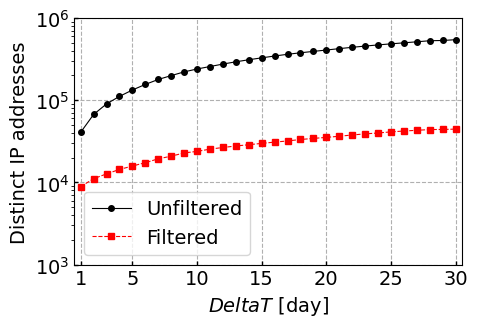

In [19]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig2b(plt, cdf, cdf_f),
                      cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.savefig('f1b_eu.eps', format='eps')
plot.show()

___
# <b>Last Day of Traffic</b> <a name="lastday"></a>



We now show characteristics of the last day of darknet traffic used in some experiments. We report in [Appendix 3](A03-darknet-checkpoint.ipynb) the scripts for generating this sample. Then we apply the filter and provide some statistics on the ground truth. Finally we extract some notable activity patterns.

In [3]:
# Load the filters
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())

In [4]:
# Load the last day of traffic
darknet_last_day = pd.read_csv(f'{DATASETS}/darkbert_G.csv.gz')
darknet_last_day.head()

,ts,ip,port,proto,pp,ts_float,class
0,2018-10-01 21:00:00.027462,9c29,23,tcp,23/tcp,1.538399e+09,unknown
1,2018-10-01 21:00:00.040712,f8c7,1047,tcp,1047/tcp,1.538399e+09,unknown
2,2018-10-01 21:00:00.068235,6a8f,3389,tcp,3389/tcp,1.538399e+09,unknown
3,2018-10-01 21:00:00.072656,5782,58569,tcp,58569/tcp,1.538399e+09,unknown
4,2018-10-01 21:00:00.073635,f07f,23,tcp,23/tcp,1.538399e+09,unknown


In [5]:
darknet_last_day = darknet

NameError: name 'darknet' is not defined

Then we apply the filter keeping the IPs sending at least 10 packets over 30 days. Then we extract some statistics about the ground truth

In [6]:
# Filter last day of traffic
pd.set_option('display.max_columns', None)
last_day  = darknet_last_day[darknet_last_day.ip.isin(filters['d30_u'])]
# last_day  = darknet_last_day[darknet_last_day.ip]
# Collect the statistics
stats = [get_last_day_stats(last_day, x) for x in last_day['class'].unique()]
pd.DataFrame(stats, columns=['Source', 'Senders', 'Packets', 
                             'Ports', 'Top-5 Ports (% Traffic)'])\
  .sort_values('Senders', ascending=False)

,Source,Senders,Packets,Ports,Top-5 Ports (% Traffic)
0,unknown,65124,4927368,28860,"23/tcp(11.6%), 445/tcp(9.9%), 1433/tcp(2.4%), ..."
1,1,3434,13694,18,"443/tcp(23.3%), 8443/tcp(15.6%), 9000/tcp(15.1..."
3,3,366,2093,17,"56409/tcp(9.2%), 63591/tcp(8.7%), 55186/tcp(8...."
2,2,91,1788,7,"102/tcp(45.3%), 11211/tcp(18.6%), 3780/tcp(11...."


In [9]:
print(stats[3][4])

56409/tcp(9.2%), 63591/tcp(8.7%), 55186/tcp(8.4%), 24357/tcp(7.4%), 21221/tcp(7.4%)


In [29]:
last_day  = darknet_last_day[darknet_last_day.ip.isin(filters['d30_f'])]
last_day

,ts,ip,port,proto,pp,ts_float,class
0,2018-10-01 00:30:00.020769,8330,2323,tcp,2323/tcp,1.538325e+09,unknown
1,2018-10-01 00:30:00.083673,e5f7,58664,tcp,58664/tcp,1.538325e+09,unknown
2,2018-10-01 00:30:00.156664,cedc,3358,tcp,3358/tcp,1.538325e+09,unknown
3,2018-10-01 00:30:00.199925,8f60,60287,tcp,60287/tcp,1.538325e+09,unknown
4,2018-10-01 00:30:00.201883,00a1,47451,tcp,47451/tcp,1.538325e+09,unknown
...,...,...,...,...,...,...,...
11309388,2018-10-31 22:49:59.889338,feb1,6127,tcp,6127/tcp,1.540997e+09,unknown
11309389,2018-10-31 22:49:59.913190,ebf0,445,tcp,445/tcp,1.540997e+09,unknown
11309390,2018-10-31 22:49:59.970699,8c3c,44821,tcp,44821/tcp,1.540997e+09,unknown
11309391,2018-10-31 22:49:59.977327,0b9a,1500,tcp,1500/tcp,1.540997e+09,unknown


### <b>Some Notable GT Activity Patterns</b> <a name="gtpattern"></a> 



By applying the same technique as before, we extract the activity patterns plot for two ground truth classes: Engin-Umich and Stretchoid.


In [44]:
# Extract the stretchoid traces from the full darknet ones
stretchoid = darknet[darknet['class'] == 'stretchoid']
stretchoid.index = pd.DatetimeIndex(stretchoid.ts)
stretchoid = stretchoid.sort_index()
# Tokenize Stretchoid IPs
ydict = {v: k for k,v in enumerate(stretchoid.ip.unique())}
stretchoid['tkn'] = stretchoid.ip.apply(lambda x: ydict[x])
# Build the activity patterns timeseries
stretchoid = stretchoid[['ip', 'tkn']]
stretchoid.head()

,ip,tkn
ts,,
2021-03-02 21:26:17.800582,192.241.228.149,0
2021-03-02 21:26:18.062857,192.241.228.149,0
2021-03-02 21:26:18.220451,192.241.228.149,0
2021-03-02 21:26:19.341073,192.241.228.149,0
2021-03-02 21:26:20.230202,192.241.228.149,0


<Figure size 640x480 with 0 Axes>

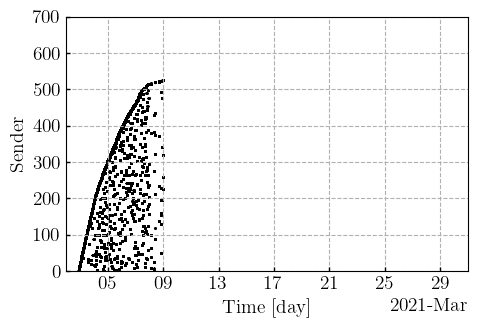

In [45]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig10a(plt, stretchoid),
                      cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.show()

In [46]:
# Extract the engin-umich traces from the full darknet ones
en_um = darknet[darknet['class'] == 'engin-umich']
en_um.index = pd.DatetimeIndex(en_um.ts)
# Tokenize Stretchoid IPs
ydict = {v: k for k,v in enumerate(en_um.ip.unique())}
en_um['tkn'] = en_um.ip.apply(lambda x: ydict[x])
# Build the activity patterns timeseries
en_um = en_um[['ip', 'tkn']]
en_um.head()

,ip,tkn
ts,,
2021-03-03 00:15:32.045996,141.212.123.185,0
2021-03-03 00:15:39.281339,141.212.123.185,0
2021-03-03 19:05:46.490620,141.212.123.185,0
2021-03-03 19:05:54.828986,141.212.123.185,0
2021-03-03 19:06:11.507999,141.212.123.185,0


<Figure size 640x480 with 0 Axes>

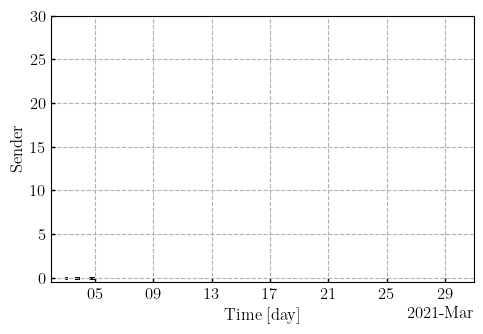

In [47]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig10b(plt, en_um),
                      cycler=cc, figsize=(5, 3.5), fontsize=12)
plot.show()

### <b>Ground Truth/Services Incidence</b> <a name="gtserv"></a> 



Generate an heatmap indicating the fraction of GT class packets sent to ports used by general-purpose services.


In [9]:
with open(f'{DATA}/services/services.json', 'r') as file:
    services = json.loads(file.read())

In [10]:
# Load the last-day unfiltered
df = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
# Load the filters
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())
# Apply the 30 days filter
df = df[df.ip.isin(set(filters['d1_f30']))]
#df = df[['ip','port', 'class', 'pp']].drop_duplicates()
# Convert poirt/procol pairs to lowercase
df.pp = df.pp.apply(lambda x: x.lower())
# Get the class of services
df['serv'] = df.pp.apply(lambda x: convert_pp(x, services))
df = df.drop(columns=['pp'])
# Add a ones column for packets sum
df['pkts'] = 1
df = df.replace({'unk_usr':'others', 'unk_sys':'others', 
                    'unk_eph':'others', 'proxy':'others'})
df.head()

,ts,ip,port,proto,class,serv,pkts
0,2021-03-31 06:29:08.691001,70.86.152.121,1433,TCP,unknown,database,1
1,2021-03-31 06:29:08.691010,70.86.152.121,1433,TCP,unknown,database,1
2,2021-03-31 06:29:08.811067,50.107.20.249,3699,TCP,unknown,others,1
3,2021-03-31 06:29:08.811073,50.107.20.249,3699,TCP,unknown,others,1
4,2021-03-31 06:29:09.119676,175.194.48.104,5555,TCP,unknown,others,1


In [11]:
pivot = df.pivot_table(values='pkts', index='class', columns='serv', 
                       aggfunc='sum')\
          .reindex(columns=df.serv.unique())\
          .fillna(.0)
pivot = pivot.divide(pivot.sum(axis=1), axis='rows').round(2).T

<Figure size 640x480 with 0 Axes>

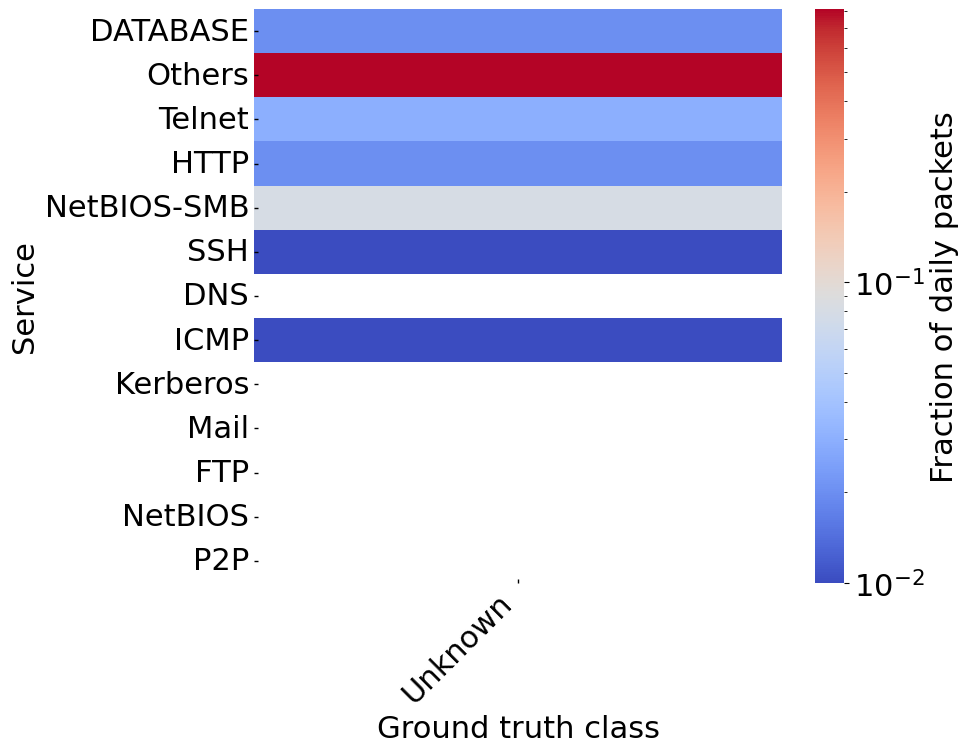

In [12]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: ground_truth_heatmap(plt, pivot),
                      figsize=(10, 8), fontsize=22, xticks_rotate=45)
plot.show()